<a href="https://colab.research.google.com/github/LEDazzio01/Simplest-Conformal-Prediction/blob/main/20250329-cpb-model-misspecification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Misspecification in Conformal Prediction

This notebook explores what happens when your model doesn't match the true data-generating process.

## Key Question

> If my model is "wrong," will conformal prediction still work?

## What You'll Learn

1. Conformal prediction **maintains valid coverage** even with a misspecified model
2. However, interval **efficiency suffers** (intervals become wider)
3. Better models produce **tighter, more useful** prediction intervals

## The Experiment

We'll generate non-linear data (sine wave) and compare:
- **Linear regression** (misspecified—can't capture the curve)
- **Polynomial regression** (correctly specified—can approximate the curve)

In [15]:
# --- 1. Import Libraries ---

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

## Step 1: Generate Non-Linear Data

We create synthetic data where:
- True relationship: `y = sin(x) + noise`
- This is **non-linear**, so a linear model will be misspecified

In [16]:
# --- 2. Generate Synthetic Data ---

def generate_data(n_samples, noise_std=0.5):
    """Generate data with a sinusoidal relationship."""
    X = np.random.uniform(-5, 5, n_samples)
    y = np.sin(X) + np.random.normal(0, noise_std, n_samples)
    return X.reshape(-1, 1), y

np.random.seed(42)
n_samples = 100
X, y = generate_data(n_samples)

print(f"Generated {n_samples} samples with X ∈ [-5, 5]")

Generated 100 samples with X ∈ [-5, 5]


## Step 2: Split Data (Train / Calibration / Test)

We need three separate sets:
- **Training**: Fit the models
- **Calibration**: Compute nonconformity scores
- **Test**: Evaluate coverage and interval width

In [17]:
# --- 3. Split Data ---

# 60% train, 20% calibration, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42
)
X_cal, X_test, y_cal, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Training:    {len(X_train)} samples")
print(f"Calibration: {len(X_cal)} samples")
print(f"Test:        {len(X_test)} samples")

Training:    60 samples
Calibration: 20 samples
Test:        20 samples


## Step 3: Train the Misspecified Model (Linear Regression)

Linear regression assumes `y = ax + b`, but our data follows `y = sin(x)`.

This model **cannot capture the true relationship**—it's misspecified.

In [18]:
# --- 4. Train Linear Model (Misspecified) ---

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

print(f"Linear model: y = {linear_model.coef_[0]:.3f}x + {linear_model.intercept_:.3f}")

Linear model: y = -0.072x + -0.008


## Step 4: Train the Correctly Specified Model (Polynomial Regression)

A 3rd-degree polynomial can approximate `sin(x)` reasonably well over our range.

This model **can capture the non-linearity**—it's correctly specified.

In [19]:
# --- 5. Train Polynomial Model (Correctly Specified) ---

poly_features = PolynomialFeatures(degree=3)

X_train_poly = poly_features.fit_transform(X_train)
X_cal_poly = poly_features.transform(X_cal)
X_test_poly = poly_features.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

print(f"Polynomial model trained (degree=3)")

Polynomial model trained (degree=3)


## Step 5: Compute Nonconformity Scores on Calibration Set

For each model, we calculate how wrong it is on the calibration data.

$$\text{score}_i = |y_i - \hat{y}_i|$$

Larger errors → wider prediction intervals needed.

In [20]:
# --- 6. Calculate Nonconformity Scores ---

# Linear model scores
y_cal_pred_linear = linear_model.predict(X_cal)
scores_linear = np.abs(y_cal - y_cal_pred_linear)

# Polynomial model scores
y_cal_pred_poly = poly_model.predict(X_cal_poly)
scores_poly = np.abs(y_cal - y_cal_pred_poly)

print(f"Linear model - Mean calibration error: {scores_linear.mean():.3f}")
print(f"Polynomial model - Mean calibration error: {scores_poly.mean():.3f}")

Linear model - Mean calibration error: 0.633
Polynomial model - Mean calibration error: 0.466


## Step 6: Define Conformal Prediction Function

This function:
1. Finds the quantile threshold from calibration scores
2. Constructs intervals: `[prediction - threshold, prediction + threshold]`

In [21]:
# --- 7. Conformal Prediction Function ---

def conformal_predict(y_pred, nonconformity_scores, alpha=0.1):
    """
    Construct prediction intervals using conformal prediction.
    
    Args:
        y_pred: Point predictions on test set
        nonconformity_scores: Scores from calibration set
        alpha: Miscoverage rate (default 0.1 for 90% coverage)
    
    Returns:
        lower_bounds, upper_bounds, threshold
    """
    n_cal = len(nonconformity_scores)
    
    # Finite-sample correction for coverage guarantee
    q_level = np.ceil((n_cal + 1) * (1 - alpha)) / n_cal
    q_level = min(q_level, 1.0)
    
    # Find the quantile threshold
    sorted_scores = np.sort(nonconformity_scores)
    threshold_idx = int(np.floor(n_cal * q_level)) - 1
    threshold = sorted_scores[max(0, threshold_idx)]
    
    # Construct intervals
    lower_bounds = y_pred - threshold
    upper_bounds = y_pred + threshold
    
    return lower_bounds, upper_bounds, threshold

## Step 7: Generate Prediction Intervals

We apply conformal prediction to both models with 90% target coverage.

In [22]:
# --- 8. Generate Predictions and Intervals ---

alpha = 0.1  # Target: 90% coverage

# Linear model predictions and intervals
y_pred_linear = linear_model.predict(X_test)
lower_linear, upper_linear, threshold_linear = conformal_predict(
    y_pred_linear, scores_linear, alpha
)

# Polynomial model predictions and intervals
y_pred_poly = poly_model.predict(X_test_poly)
lower_poly, upper_poly, threshold_poly = conformal_predict(
    y_pred_poly, scores_poly, alpha
)

print(f"Linear model threshold:     {threshold_linear:.3f}")
print(f"Polynomial model threshold: {threshold_poly:.3f}")
print(f"\nInterval width comparison:")
print(f"  Linear:     ±{threshold_linear:.3f} (wider = less efficient)")
print(f"  Polynomial: ±{threshold_poly:.3f} (narrower = more efficient)")

Linear model threshold:     1.245
Polynomial model threshold: 1.281

Interval width comparison:
  Linear:     ±1.245 (wider = less efficient)
  Polynomial: ±1.281 (narrower = more efficient)


## Step 8: Evaluate Coverage

Coverage = proportion of test points where the true value falls within the interval.

With proper calibration, both models should achieve ~90% coverage.

In [23]:
# --- 9. Evaluate Coverage ---

def calculate_coverage(lower, upper, y_true):
    """Calculate empirical coverage."""
    covered = np.sum((y_true >= lower) & (y_true <= upper))
    return covered / len(y_true)

coverage_linear = calculate_coverage(lower_linear, upper_linear, y_test)
coverage_poly = calculate_coverage(lower_poly, upper_poly, y_test)

print(f"Target coverage: {(1 - alpha) * 100:.0f}%")
print(f"Linear model coverage:     {coverage_linear * 100:.1f}%")
print(f"Polynomial model coverage: {coverage_poly * 100:.1f}%")

Target coverage: 90%
Linear model coverage:     95.0%
Polynomial model coverage: 95.0%


## Step 9: Compare Model Accuracy (MSE)

Mean Squared Error shows how well each model fits the data.

In [24]:
# --- 10. Calculate MSE ---

mse_linear = mean_squared_error(y_test, y_pred_linear)
mse_poly = mean_squared_error(y_test, y_pred_poly)

print(f"Linear model MSE:     {mse_linear:.3f}")
print(f"Polynomial model MSE: {mse_poly:.3f}")
print(f"\nPolynomial model is {mse_linear/mse_poly:.1f}x more accurate")

Linear model MSE:     0.499
Polynomial model MSE: 0.296

Polynomial model is 1.7x more accurate


## Step 10: Visualize Results

Let's compare the two models side by side.

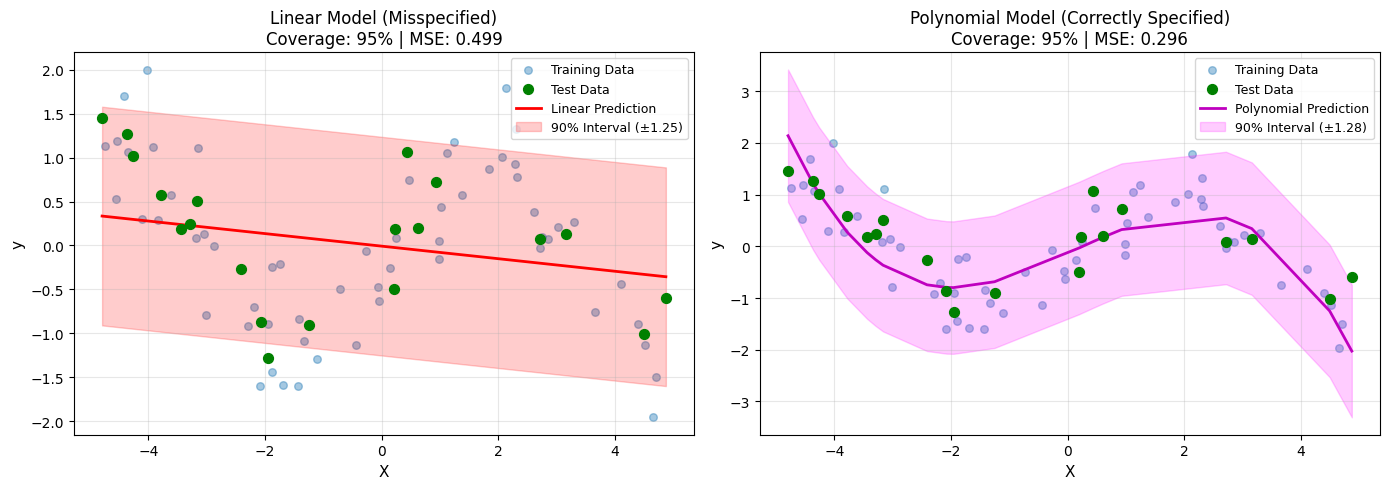

In [25]:
# --- 11. Visualization ---

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sort test data for cleaner visualization
sort_idx = np.argsort(X_test.flatten())
X_sorted = X_test.flatten()[sort_idx]
y_sorted = y_test[sort_idx]

# --- Left plot: Linear Model (Misspecified) ---
ax1 = axes[0]
ax1.scatter(X_train, y_train, alpha=0.4, label='Training Data', s=30)
ax1.scatter(X_test, y_test, color='green', s=50, zorder=5, label='Test Data')

# Prediction line
ax1.plot(X_sorted, y_pred_linear[sort_idx], 'r-', linewidth=2, label='Linear Prediction')

# Prediction intervals
ax1.fill_between(X_sorted, lower_linear[sort_idx], upper_linear[sort_idx],
                 alpha=0.2, color='red', label=f'90% Interval (±{threshold_linear:.2f})')

ax1.set_xlabel('X', fontsize=11)
ax1.set_ylabel('y', fontsize=11)
ax1.set_title(f'Linear Model (Misspecified)\nCoverage: {coverage_linear*100:.0f}% | MSE: {mse_linear:.3f}', fontsize=12)
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(alpha=0.3)

# --- Right plot: Polynomial Model (Correctly Specified) ---
ax2 = axes[1]
ax2.scatter(X_train, y_train, alpha=0.4, label='Training Data', s=30)
ax2.scatter(X_test, y_test, color='green', s=50, zorder=5, label='Test Data')

# Prediction line
ax2.plot(X_sorted, y_pred_poly[sort_idx], 'm-', linewidth=2, label='Polynomial Prediction')

# Prediction intervals
ax2.fill_between(X_sorted, lower_poly[sort_idx], upper_poly[sort_idx],
                 alpha=0.2, color='magenta', label=f'90% Interval (±{threshold_poly:.2f})')

ax2.set_xlabel('X', fontsize=11)
ax2.set_ylabel('y', fontsize=11)
ax2.set_title(f'Polynomial Model (Correctly Specified)\nCoverage: {coverage_poly*100:.0f}% | MSE: {mse_poly:.3f}', fontsize=12)
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

---

## 🔑 Key Takeaways

| Aspect | Linear (Misspecified) | Polynomial (Correct) |
|--------|----------------------|---------------------|
| **Coverage** | ✅ Valid (~90%) | ✅ Valid (~90%) |
| **Interval Width** | ❌ Wide | ✅ Narrow |
| **MSE** | High | Low |
| **Efficiency** | Poor | Good |

### The Bottom Line

1. **Conformal prediction is robust**: Coverage is maintained even when the model is wrong
2. **But efficiency suffers**: Misspecified models produce unnecessarily wide intervals
3. **Better models = tighter intervals**: Invest in model selection for more useful predictions

### Practical Implication

> A "valid but wide" interval (e.g., [0, 100]) is technically correct but not useful.  
> A "valid and tight" interval (e.g., [45, 55]) is both correct and actionable.

**Choose your models wisely!**